# <h1 align="center"> **ENEL 503: Computer Vision (W2025)**

# <h2 align="center">**Lab4: Lane Detection and Image Classifcation**

***General Notes:***

* Download the lab4 images from D2L to your lab4 folder.
* You can add this folder to your Google Drive and access it through Google Colab or work in the real-time workspace, but you must upload your images there.
* This lab can be done in groups of 2 students. <ins>Only one submission with both names on the report</ins>
* The due date to submit this lab is March 28 at 11:59 pm
* Read the lab instructions carefully and make sure you respond to all the open questions and coding tasks.
* After finishing your work, save this notebook with its ".ipynb" extension and another version as "pdf". Then, upload both files to D2L Dropbox.
* Don't forget to write your names and student IDs below.

---


**Student Name:** Aarushi Roy Choudhury

**Student ID:** 30113987

Worked individually

---



---

## Objectives

In this lab, you will learn the following:

- Lane Detection using Hough Transform
- Implement your own kNN classifier
- Implement a simple Softmax clasifier
- Apply the SVM clasifier from `sklearn`


 Parts of this lab is adapted from:

 - Homeworks of the CS231n course at Stanford University.
 - Labs of the CSE 445 course at University of Washington

## Setup

### **Step 1**

In [28]:
# Run this part if you want to mount your Google Drive to Colab VM and
# work on your lab folder directly. Make sure to enter the correct path to your
# folder. Otherwise, you can work on the realtime workspace but you will need
# to upload your images.

from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# lab folder, e.g. 'Colab Notebooks/ENEL503/Lab4'
FOLDERNAME = 'Colab Notebooks/ENEL_503_Lab4' #None
assert FOLDERNAME is not None, "[!] Enter the foldername."
FullPath = '/content/drive/MyDrive/' + FOLDERNAME
print(FullPath)

import os
os.chdir(FullPath)
!pwd # check that your folder is the current working directory

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append(FullPath)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ENEL_503_Lab4
/content/drive/MyDrive/Colab Notebooks/ENEL_503_Lab4


### **Step 2**
Next, run the cells below to install the necessary libraries and packages.

In [29]:
# Check the Python version
!python --version

# Install the required packages (uncomment if not on Google Colab or not already installed on your env)
# %pip install numpy
# %pip install matplotlib
# %pip install opencv-python
# %pip install scikit-image
# %pip install scipy
# %pip install six


Python 3.11.11


In [30]:
# Imports the print function from newer versions of python
from __future__ import print_function

# Numpy is the main package for scientific computing with Python.
# This will be one of our most used libraries in this class
import numpy as np
from data_utils import load_CIFAR10

import cv2 as cv

# from utils import pad, unpad, get_output_space, warp_image, plot_matches

# Matplotlib is a useful plotting library for python
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part 1: Lane Detection

In this section we will implement a simple lane detection application using Canny edge detector and Hough transform.

The algorithm can broken down into the following steps:
1. Detect edges using the Canny edge detector.
2. Extract the edges in the region of interest (a triangle covering the bottom corners and the center of the image).
3. Run Hough transform to detect lanes.


## 1.1 Edge detection
Lanes on the roads are usually thin and long lines with bright colors. Edge detection algorithms should be able to find the lanes pretty well. Edit the code cell below to load the example image and detect edges from the image.

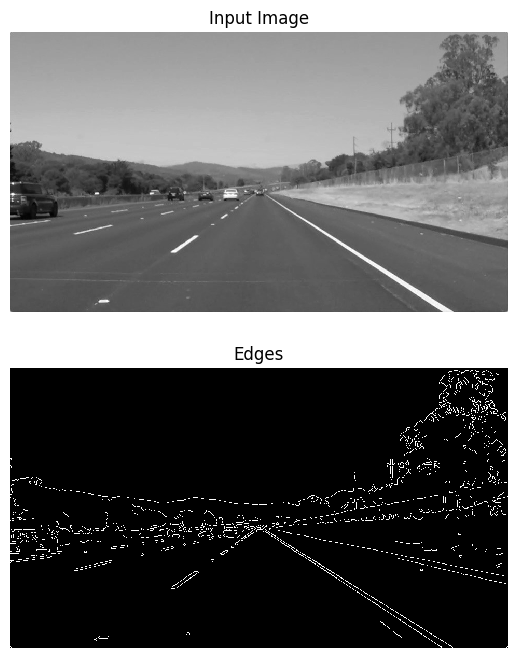

In [31]:
# Load image
img = cv.imread('road.jpg', cv.IMREAD_GRAYSCALE)

#### Run Canny edge detector ###############################################
# Apply the function 'cv.Canny' the same way you did in lab 2 to extract the edges
# Remember to apply a `GaussianBlur` first
# You can try differrent parameters but set the final parameters to:
# GaussinBlur: kernel size=5x5, sigmax = sigmaY=1.4,
# Canny: high_threshold=0.3*255, low_threshold=0.2*255

### YOUR CODE HERE  (Don't delete this line)

# Apply GaussianBlur with a 5x5 kernel & sigma 1.4
blurred = cv.GaussianBlur(img, (5, 5), 1.4)

# Then apply the Canny edge detector with given thresholds
edges = cv.Canny(blurred, int(0.2 * 255), int(0.3 * 255))


### End YOUR CODE (Don't delete this line)

plt.subplot(211)
plt.imshow(img)
plt.axis('off')
plt.title('Input Image')

plt.subplot(212)
plt.imshow(edges)
plt.axis('off')
plt.title('Edges')
plt.show()

## 1.2 Extracting region of interest (ROI)

An important concept in image segmentation and object detection is the "Region of Interest" (ROI) in which you work only in the part of the image that is expected to contain your object.

In our case, the Canny edge detector could find the edges of the lanes. However, we can also see that there are edges of other objects that we are not interested in. Given the position and orientation of the camera, we know that the lanes will be located in the lower half of the image. The code below defines a binary mask for the ROI and extracts the edges within the region.

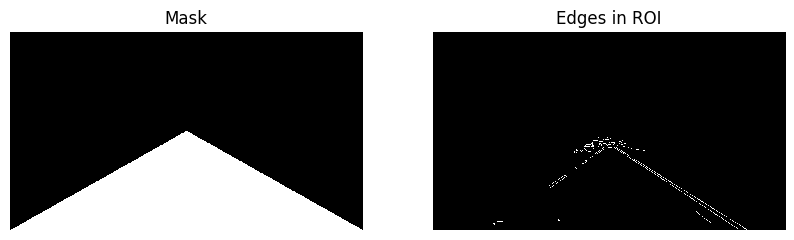

In [32]:
H, W = img.shape

# Generate mask for ROI (Region of Interest)
mask = np.zeros((H, W))
for i in range(H):
    for j in range(W):
        if i > (H / W) * j and i > -(H / W) * j + H:
            mask[i, j] = 1

# Extract edges in ROI
roi = edges * mask

plt.subplot(1,2,1)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(roi)
plt.title('Edges in ROI')
plt.axis('off')
plt.show()

## 1.3 Fitting lines using Hough transform <font color='green'> (5 Marks)</font>
The output from the edge detector is still a collection of connected points. However, it would be more natural to represent a lane as a line parameterized as $y = ax + b$, with a slope $a$ and y-intercept $b$. We will use Hough transform to find parameterized lines that represent the detected edges.

In general, a straight line $y = ax + b$ can be represented as a point $(a, b)$ in the parameter space. This is the parameterization we often use when introducing the Hough transform.  However, this cannot represent vertical lines as the slope parameter will be unbounded. Alternatively, we parameterize a line using $\theta\in{[-\pi, \pi]}$ and $\rho\in{\mathbb{R}}$ as follows:

$$
\rho = x\cdot{cos\theta} + y\cdot{sin\theta}
$$

Using this parameterization, we can map every point in $xy$-space to a sine-like line in $\theta\rho$-space (or Hough space). We then accumulate the parameterized points in the Hough space and choose points (in Hough space) with highest accumulated values. A point in Hough space then can be transformed back into a line in $xy$-space.

In [33]:
def hough_transform(img):
    """ Transform points in the input image into Hough space.

    Use the parameterization:
        rho = x * cos(theta) + y * sin(theta)
    to transform a point (x,y) to a sine-like function in Hough space.

    Args:
        img: binary image of shape (H, W).

    Returns:
        accumulator: numpy array of shape (m, n).
        rhos: numpy array of shape (m, ).
        thetas: numpy array of shape (n, ).
    """
    # Set rho and theta ranges
    H, W = img.shape
    diag_len = int(np.ceil(np.sqrt(W * W + H * H)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2 + 1)
    thetas = np.deg2rad(np.arange(-90.0, 90.0))

    # Cache some reusable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Initialize accumulator in the Hough space
    accumulator = np.zeros((2 * diag_len + 1, num_thetas), dtype=np.uint64)
    ys, xs = np.nonzero(img)

    # Transform each point (x, y) in image
    # Find rho corresponding to values in thetas
    # and increment the accumulator in the corresponding coordiate.

    ### YOUR CODE HERE (Don't delete this line)

    for i in range(len(xs)):
        x = xs[i]
        y = ys[i]
        # Compute the corresponding rho values for all thetas
        rho_vals = x * cos_t + y * sin_t
        # Map rho values to the accumulator index
        rho_indices = np.round(rho_vals).astype(int) + diag_len
        # Increment the accumulator for each theta at the computed rho index
        accumulator[rho_indices, np.arange(num_thetas)] += 1

    ### END YOUR CODE (Don't delete this line)

    return accumulator, rhos, thetas

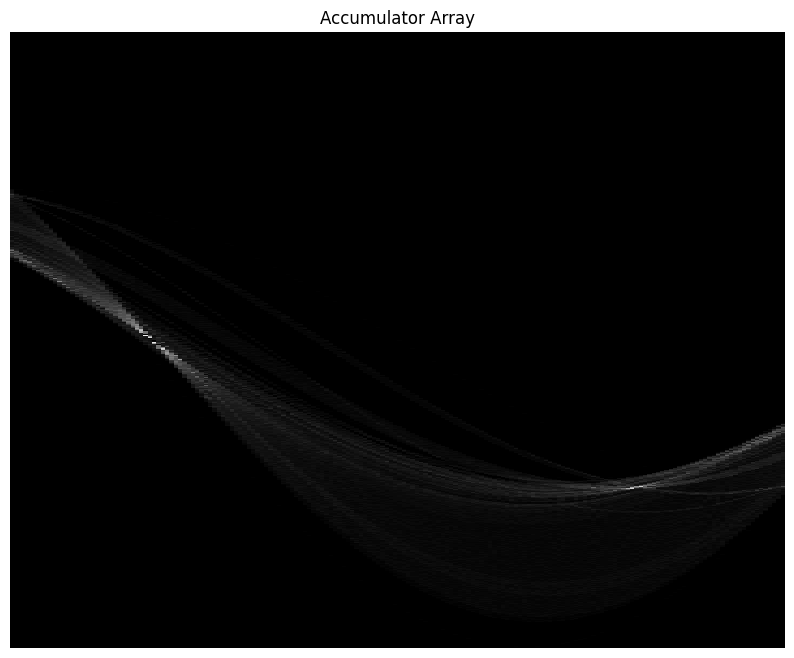

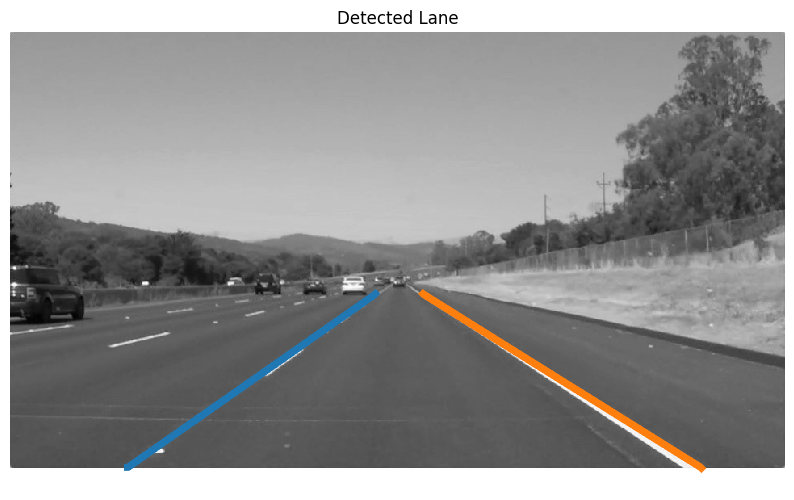

In [34]:
# Perform Hough transform on the ROI
acc, rhos, thetas = hough_transform(roi)

# Coordinates for right lane
xs_right = []
ys_right = []

# Coordinates for left lane
xs_left = []
ys_left = []

for i in range(20):
    idx = np.argmax(acc)
    r_idx = idx // acc.shape[1]
    t_idx = idx % acc.shape[1]
    acc[r_idx, t_idx] = 0 # Zero out the max value in accumulator

    rho = rhos[r_idx]
    theta = thetas[t_idx]

    # Transform a point in Hough space to a line in xy-space.
    a = - (np.cos(theta)/np.sin(theta)) # slope of the line
    b = (rho/np.sin(theta)) # y-intersect of the line

    # Break if both right and left lanes are detected
    if xs_right and xs_left:
        break

    if a < 0: # Left lane
        if xs_left:
            continue
        xs = xs_left
        ys = ys_left
    else: # Right Lane
        if xs_right:
            continue
        xs = xs_right
        ys = ys_right

    for x in range(img.shape[1]):
        y = a * x + b
        if y > img.shape[0] * 0.6 and y < img.shape[0]:
            xs.append(x)
            ys.append(int(round(y)))

# plt.subplot(211)
plt.imshow(acc, interpolation='nearest', aspect='auto')
plt.axis('off')
plt.title('Accumulator Array')
plt.show()

# plt.subplot(212)
plt.imshow(img)
plt.plot(xs_left, ys_left, linewidth=5.0)
plt.plot(xs_right, ys_right, linewidth=5.0)
plt.axis('off')
plt.title('Detected Lane')
plt.show()


# Part 2: Image Classification

In this section, we will investigate the performance of some image classifiers, namely k-Nearest Neighbors (kNN), Softmax, and Support Vector Machine (SVM). We will use the CIFAR10 dataset.


## 2.1 k-Nearest Neighbor (kNN)

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

First, let's start with downloading the data

In [35]:
cifar10_dir = 'datasets/cifar-10-batches-py'
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


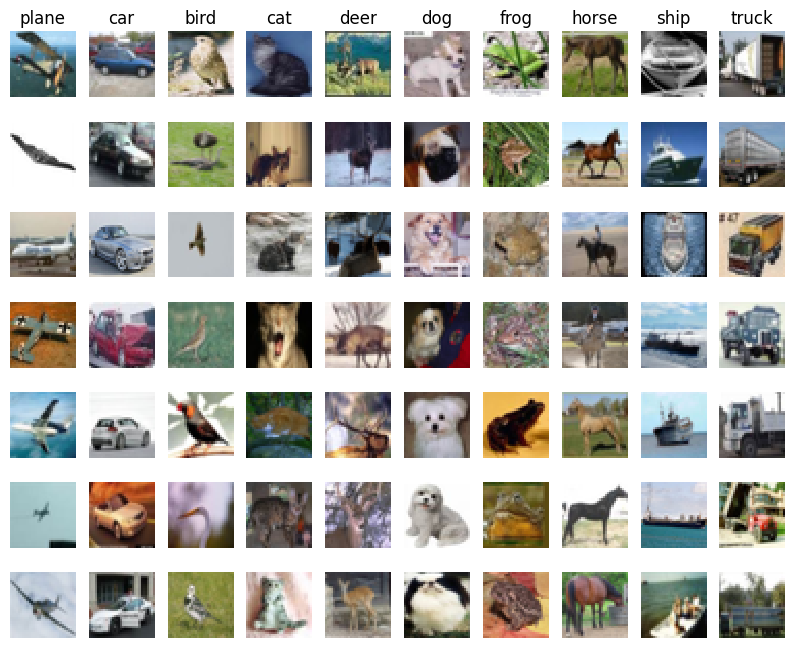

In [36]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [37]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


### 2.1.1 Implement the KNearestNeighbor Classifier <font color='green'> (10 Marks)</font>

Edit the code cell below to finalize the class implementation of kNN classifier.

In [38]:
class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """
    def __init__(self):
        pass

    def train(self, X, y):
        """
        Train the classifier. For k-nearest neighbors this is just
        memorizing the training data.

        Inputs:
        - X: A numpy array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1):
        """
        Predict labels for test data using this classifier.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting
             of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        dists = self.compute_distances(X)
        return self.predict_labels(dists, k=k)

    def compute_distances(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.

        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the Euclidean distance between the ith test point and the jth training
          point.

        Notes:
        - Calculating the distances can be done using two for loops (over
          num_test and num_train), one for loop (over num_test), or in a
          vectorized style (without for loops using matrix multiplication).
        - Any solution is accepted and they all should give the same distances,
          but the vectorized way would be faster in a realtime application
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))

        #####################################################################
        # TODO:                                                             #
        # Compute the l2 distance between the ith test point and the jth    #
        # training point, and store the result in dists[i, j]. You should   #
        # not use a scipy function, nor use np.linalg.norm().          #
        #####################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Using vectorized approach
        # (x - y)^2 = x^2 + y^2 - 2*x*y
        dists = np.sqrt(np.sum(X**2, axis=1, keepdims=True) +
                        np.sum(self.X_train**2, axis=1) -
                        2 * np.dot(X, self.X_train.T))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists


    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith test point.
            closest_y = []
            #########################################################################
            # TODO:                                                                 #
            # Use the distance matrix to find the k nearest neighbors of the ith    #
            # testing point, and use self.y_train to find the labels of these       #
            # neighbors. Store these labels in closest_y.                           #
            # Hint: Look up the function numpy.argsort.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Find the indices of the k smallest distances
            closest_indices = np.argsort(dists[i])[:k]
            # Retrieve the labels of k neighbors
            closest_y = self.y_train[closest_indices]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            #########################################################################
            # TODO:                                                                 #
            # Now that you have found the labels of the k nearest neighbors, you    #
            # need to find the most common label in the list closest_y of labels.   #
            # Store this label in y_pred[i]. Break ties by choosing the smaller     #
            # label.                                                                #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Determine most common label among neighbors
            # np.bincount counts occurrences,  np.argmax returns the smallest label in case of tie
            y_pred[i] = np.argmax(np.bincount(closest_y))

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return y_pred


In [39]:
# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [40]:
# Verify your distance calculation against scipy.cdist
from scipy.spatial.distance import cdist
dists_scipy = cdist(X_test, X_train, 'euclidean')
dists = classifier.compute_distances(X_test)

difference = np.linalg.norm(dists - dists_scipy, ord='fro')
print('Distance difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Distance difference was: 0.000000
Good! The distance matrices are the same


In [41]:
# Now let's test our classifier with k = 1(which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:


In [42]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

### 2.1.2 Cross-validation <font color='green'> (8 Marks)</font>

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validatio

In [43]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for k in k_choices:
    k_to_accuracies[k] = []  # initialize the list of accuracies for this k
    for i in range(num_folds):
        # Use the i-th fold as valid set & rest as train set
        X_val = X_train_folds[i]
        y_val = y_train_folds[i]
        X_train_cv = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:], axis=0)
        y_train_cv = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:], axis=0)

        # Train classifier & predict on valid set
        classifier = KNearestNeighbor()
        classifier.train(X_train_cv, y_train_cv)
        y_val_pred = classifier.predict(X_val, k=k)
        accuracy = np.mean(y_val_pred == y_val)
        k_to_accuracies[k].append(accuracy)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

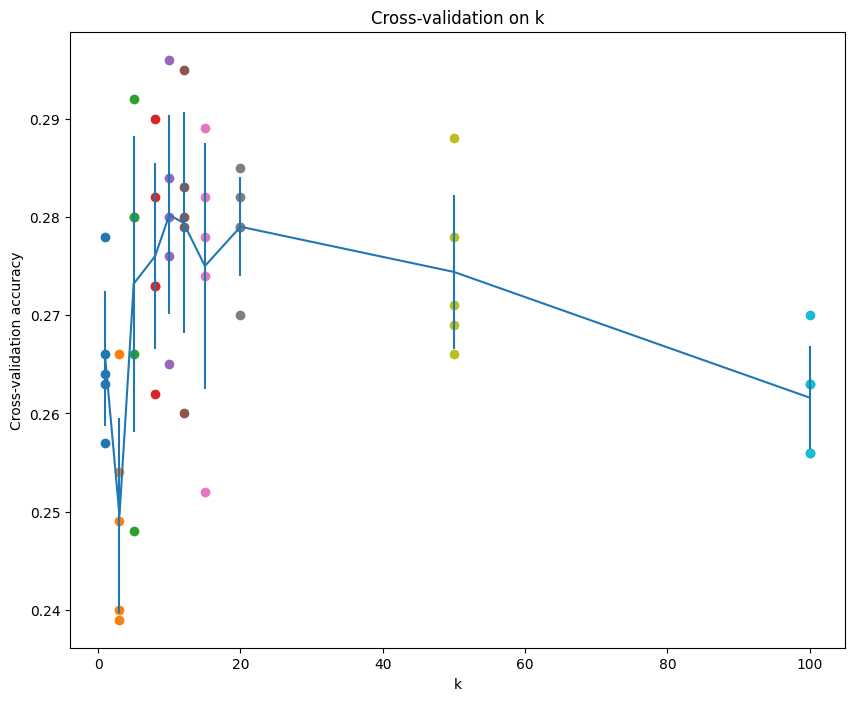

In [44]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [45]:
# Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10 # k = 10 had the highest mean accuracy of 28.02%

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


## 2.2 Softmax Classifier <font color='green'>(10 Marks)</font>

In softmax regression, the key idea is to compute the probabilities of an input belonging to each class and then predict the class with the highest probability. The output of the softmax regression is a probability distribution over all possible classes, and the class with the highest chance is chosen as the predicted class.

Below is a simple implementation of the Softmax Classifier:


1. Go through the code to understand the training process using the gradient descent algorithm to calculate the hyperparameters.
2. Notice how the training is based on minimizing the cross-entropy loss discussed in the lecture.   
3. Complete the code to perform the prediction part and check the resulting classification accuracy <font color='green'>(7 Marks)</font>.





In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
np.random.seed(1200)

# Number of classes
num_classes = len(np.unique(y_train))

# Add bias term to feature matrix
X_train_bias = np.hstack((X_train, np.ones((X_train.shape[0], 1))))
X_test_bias = np.hstack((X_test, np.ones((X_test.shape[0], 1))))

# Initialize weights randomly
num_features = X_train_bias.shape[1]
weights = np.random.randn(num_features, num_classes)

# Training parameters
learning_rate = 0.01
num_epochs = 1000

# Training loop
for epoch in range(num_epochs):
    # Compute logits (linear combinations)
    logits = X_train_bias.dot(weights)  # z_i = Wx_i (bias is included in x_i)

    # shift the maximum to 0 for numrical stability (https://cs231n.github.io/linear-classify/)
    # without this shift, the accuracy can be degraded.
    logits -= np.max(logits, axis=1, keepdims=True)
    # Apply softmax function to logits
    exp_logits = np.exp(logits)    #e^z
    softmax_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)#e^z_i/sum(e^z_j)

    # Compute gradient of cross-entropy loss with respect to weights
    gradients = X_train_bias.T.dot(softmax_probs - np.eye(num_classes)[y_train])

    # Update weights
    delta = learning_rate * gradients
    weights -= delta

# Predictions
# Hint: Calculate the output if the input was X_test_bias
# Hint: calculate the test logits, apply softmax, and determine the output class
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)**********************

# Compute logits for test data
logits_test = X_test_bias.dot(weights)
# Apply numerical stability trick
logits_test -= np.max(logits_test, axis=1, keepdims=True)
# Apply softmax to compute probabilities
exp_logits_test = np.exp(logits_test)
softmax_probs_test = exp_logits_test / np.sum(exp_logits_test, axis=1, keepdims=True)
# Predict the class with highest probability
y_pred = np.argmax(softmax_probs_test, axis=1)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)************************

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.29


In practice, you might want to use more sophisticated optimization techniques, regularization, and proper data preprocessing to achieve better results.

### <font color='green'>Question (3 Marks)</font>  
If the accuracy is still comparable to the kNN classifier, what are the advantages of a Softmax classifier over a kNN classifier?

<font color='red'>Edit the cell and write your answer below (DON'T DELETE THIS LINE)</font>.

While kNN is easy to understand and implement, it is not very practical, especially if you have a large dataset. kNN computes distance between the test  point and EVERY other point! So its very computationally expensive. But Softmax, after its trained, predicts by computing a dot product and applying softmax function. So softmax is much more memory efficient and scales better.


## 2.3 Support Vector Machine (SVM) <font color='green'>(10 Marks)</font>

In this section, we want to investigate the performance of the SVM classifier module in the `sklearn` package. First, we will assume a "linear" kernel, i.e., assuming the data is linearly separable. Second, we will use a nonlinear kernel. Finally, you can change the classifier kernel and regularization parameters to enhance the performance.

In [47]:
from sklearn import svm

# Create a linear SVM classifier with regularization C = 1
svm_classifier = svm.SVC(kernel='linear', C=1)

# Write your code to train the classifier and then predict the test results
# Hint: check for the 'fit' and 'predict' methods
# You can still use the variables X_trian, y_train, X_test, y_test

### YOUR CODE HERE (Don't delete this line)

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Predict on the test data
predicted_data = svm_classifier.predict(X_test)

### YOUR CODE END (Don't delete this line)


Now, let's check the accuracy. You will see somthing close to the kNN accuracy

In [48]:
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(y_test, predicted_data))

Accuracy: 0.28


If the data is not linearly separable, the SVM can utilize a nonlinear kernel for better classification. Re-define your classifier and use the default parameters or strictly set it as `'kernel'='rbf',C=1`. You will notice a significant improvement in accuracy.

In [49]:
# Redesign your classifier with 'kernel'='rbf',C=1

### YOUR CODE HERE (Don't delete this line)

svm_classifier = svm.SVC(kernel='rbf', C=1)
svm_classifier.fit(X_train, y_train)
predicted_data = svm_classifier.predict(X_test)

### YOUR CODE END (Don't delete this line)
print("Accuracy:", metrics.accuracy_score(y_test, predicted_data))

Accuracy: 0.404


Now, you can do your final design, where you can change the kernel or regularization parameters (or any other parameters you want to try). The target is to get an accuracy better, even with a small amount, than the one you obtained with the default parameters above.

In [50]:
# Redesign your classifier with parameters of your choice
### YOUR CODE HERE (Don't delete this line)

svm_classifier = svm.SVC(kernel='rbf', C=10) #  I tried increasing regularization parameter C to 10 (increasing the penalty for misclassification)
svm_classifier.fit(X_train, y_train)
predicted_data = svm_classifier.predict(X_test)

### YOUR CODE END (Don't delete this line)
print("Accuracy:", metrics.accuracy_score(y_test, predicted_data))

Accuracy: 0.446


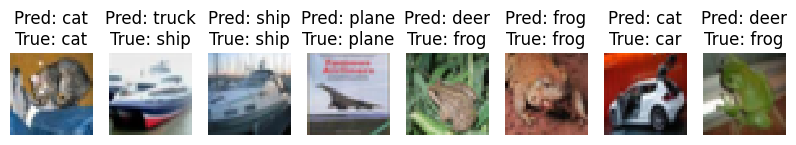

In [51]:
# Evaluate the model (show sample results) [ensure the variables match your codes]
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

_, axes = plt.subplots(nrows=1, ncols=8, figsize=(10, 3))
for ax, image, prediction,label in zip(axes, X_test, predicted_data,y_test):
    ax.set_axis_off()
    image = image.reshape(32, 32,3)
    ax.imshow(image.astype('uint8'), interpolation="nearest")
    ax.set_title(f"Pred: {classes[prediction]}\nTrue: {classes[label]}")


Accuracy: 0.446
Confusion matrix:
[[25  0  2  2  3  2  2  4 13  4]
 [ 4 21  1  1  1  0  0  2  4  7]
 [ 4  2 26  3  4  6  3  2  1  0]
 [ 2  3  6 14  1 12  4  3  2  2]
 [ 2  2  8  2 11  2  5  5  1  2]
 [ 2  2  3  9  5 18  2  5  2  0]
 [ 1  1  2  4 14  1 28  1  2  0]
 [ 1  2  5  4  6  4  1 18  2  4]
 [ 8  1  2  2  0  3  0  0 36  5]
 [ 4  8  1  2  0  1  2  5  7 26]]


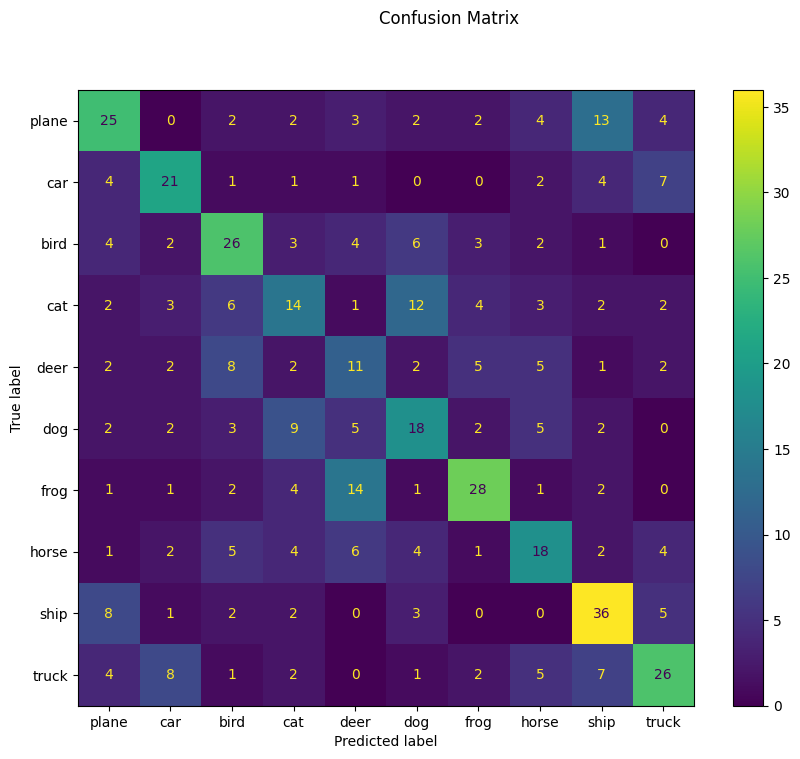

In [52]:
# Evaluate the model (quantitative metrics) [ensure the variables match your codes]
print("Accuracy:", metrics.accuracy_score(y_test, predicted_data))
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_data, display_labels=classes)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

In [ ]:
%pip install nbconvert

!apt-get install texlive texlive-xetex texlive-latex-extra pandoc.

In [54]:
!jupyter nbconvert --to pdf ENEL503_lab4.ipynb

[NbConvertApp] Converting notebook ENEL503_lab4.ipynb to pdf
[NbConvertApp] Support files will be in ENEL503_lab4_files/
[NbConvertApp] Making directory ./ENEL503_lab4_files
[NbConvertApp] Writing 297029 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 827463 bytes to ENEL503_lab4.pdf
